In [56]:
import pandas as pd
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import timedelta
from operator import attrgetter
from scipy import stats
from scipy.stats import bootstrap
import pandahouse as ph
%matplotlib inline 

In [57]:
df_groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep=';')
# id - id пользователя
# grp - принадлежность пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

df_groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
#  дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

df_active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

df_checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep=';')
# файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [61]:
df_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [62]:
df_groups_add.head(91)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
86,200247816,B
87,200247820,B
88,201032527,B
89,201067612,B


In [63]:
df_active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [64]:
df_checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


### Проверка на пропущенные значения 

In [65]:
print("Пропущенные значения в groups:")
print(df_groups.isnull().sum())
print("\nПропущенные значения в groups_add:")
print(df_groups_add.isnull().sum())
print("\nПропущенные значения в active_studs:")
print(df_active_studs.isnull().sum())
print("\nПропущенные значения в checks:")
print(df_checks.isnull().sum())

Пропущенные значения в groups:
id     0
grp    0
dtype: int64

Пропущенные значения в groups_add:
id     0
grp    0
dtype: int64

Пропущенные значения в active_studs:
student_id    0
dtype: int64

Пропущенные значения в checks:
student_id    0
rev           0
dtype: int64


### Проверка на пропущенные значения 

In [66]:
print("\nДубликаты в groups:")
print(df_groups.duplicated().sum())
print("\nДубликаты в groups_add:")
print(df_groups_add.duplicated().sum())
print("\nДубликаты в active_studs:")
print(df_active_studs.duplicated().sum())
print("\nДубликаты в checks:")
print(df_checks.duplicated().sum())


Дубликаты в groups:
0

Дубликаты в groups_add:
0

Дубликаты в active_studs:
0

Дубликаты в checks:
0


Проверка на пропущеные значения.

### Посчитаем сколько юзеров в каждой группе

In [67]:
count_users = df_groups\
    .groupby('grp', as_index=False)\
    .agg({'id': 'count'})\
    .rename(columns={'id': 'count_users'})
count_users

,grp,count_users
0,A,14671
1,B,59813


In [68]:
# Считаем общее количество пользователей
total_users = count_users['count_users'].sum()

# Добавляем новый столбец с процентами
count_users['percentage'] = (count_users['count_users'] / total_users) * 100

# Проверяем результат
print(count_users)

  grp  count_users  percentage
0   A        14671   19.696848
1   B        59813   80.303152


#### А - контрольная группа 14617; B - эксперементальная 59813, A = 19.69% B = 80.30%

In [69]:
count_users_add = df_groups_add\
    .groupby('grp', as_index=False)\
    .agg({'id': 'count'})\
    .rename(columns={'id': 'count_users_add'})
count_users_add
#

,grp,count_users_add
0,A,22
1,B,70


In [70]:
count_users = pd.DataFrame({
    'grp': ['A', 'B'],
    'count_users_add': [22, 70]
})

# Считаем общее количество пользователей
total_users = count_users['count_users_add'].sum()

# Добавляем новый столбец с процентами
count_users['percentage'] = (count_users['count_users_add'] / total_users) * 100

# Проверяем результат
print(count_users)

  grp  count_users_add  percentage
0   A               22   23.913043
1   B               70   76.086957


#### А - контрольная группа 22; B - эксперементальная 70, A = 23.91%, B = 76.08%

In [71]:
df_active_studs.count()
#активных пользователей - 8341

student_id    8341
dtype: int64

##### Активных пользователей - 8341

In [72]:
# Подсчет уникальных student_id
unique_students = df_checks['student_id'].nunique()
print(f"Количество уникальных student_id: {unique_students}")
# Подсчет суммы rev
total_rev = df_checks['rev'].sum()
print(f"Сумма rev: {total_rev}")

Количество уникальных student_id: 541
Сумма rev: 573326.0035999999


#### Количество уникальных student_id: 541
#### Сумма rev: 573326


### Объединим данные, чтобы получить полную картину о пользователях, их группах и оплатах.

In [73]:
# Объединяем группы с активными пользователями
active_groups = df_groups.merge(df_active_studs, left_on='id', right_on='student_id', how='inner')

# Объединяем с данными об оплатах
active_checks = active_groups.merge(df_checks, on='student_id', how='left')

# Проверяем результат
print(active_checks.head())


     id grp  student_id    rev
0  1627   A        1627  990.0
1  2085   B        2085    NaN
2  2215   B        2215    NaN
3  3391   A        3391    NaN
4  3401   B        3401    NaN


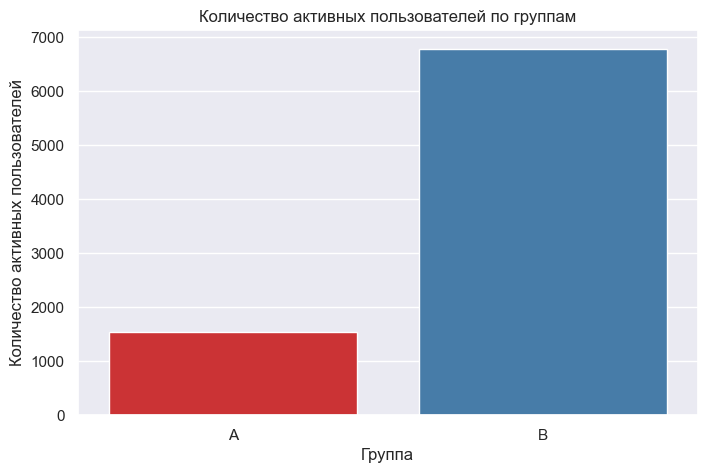

In [74]:
#Счетчик активных пользователей по группам
plt.figure(figsize=(8, 5))
sns.countplot(data=active_checks, x='grp', palette='Set1')
plt.title('Количество активных пользователей по группам')
plt.xlabel('Группа')
plt.ylabel('Количество активных пользователей')
plt.show()

In [75]:
# Подсчет количества уникальных пользователей, совершивших оплату по группам
payment_counts = active_checks[active_checks['rev'].notnull()].groupby('grp')['student_id'].nunique()

# Вывод результата
print(payment_counts)


grp
A     78
B    313
Name: student_id, dtype: int64


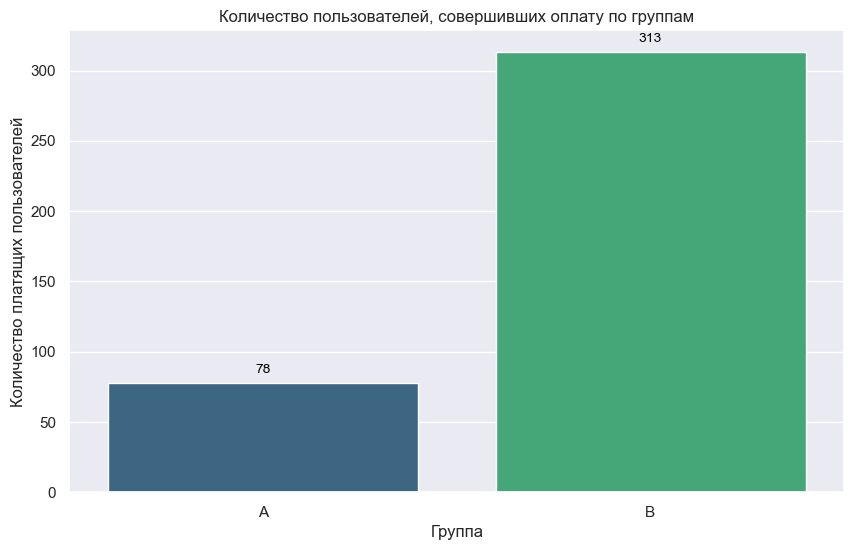

In [76]:
# Подсчет количества уникальных пользователей, совершивших оплату по группам
payment_counts = active_checks[active_checks['rev'].notnull()].groupby('grp')['student_id'].nunique().reset_index()

# Переименование столбцов для удобства
payment_counts.columns = ['Group', 'Paying Users']

# Визуализация
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=payment_counts, x='Group', y='Paying Users', palette='viridis')
plt.title('Количество пользователей, совершивших оплату по группам')
plt.xlabel('Группа')
plt.ylabel('Количество платящих пользователей')
plt.xticks(rotation=0)  # Поворот меток по оси X для лучшей читаемости

# Добавление подписей на столбцы
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=10, color='black', 
                      xytext=(0, 5),  # Смещение подписи
                      textcoords='offset points')

plt.show()

In [77]:
# Подсчет количества уникальных пользователей, не совершивших оплату по группам
non_payment_counts = active_checks[active_checks['rev'].isnull()].groupby('grp')['student_id'].nunique().reset_index()

# Переименование столбцов для удобства
non_payment_counts.columns = ['Group', 'Non-Paying Users']

# Вывод результата
print(non_payment_counts)

  Group  Non-Paying Users
0     A              1457
1     B              6480


#### Количество уникальных пользователей, не совершивших оплату A = 1457, B = 6480

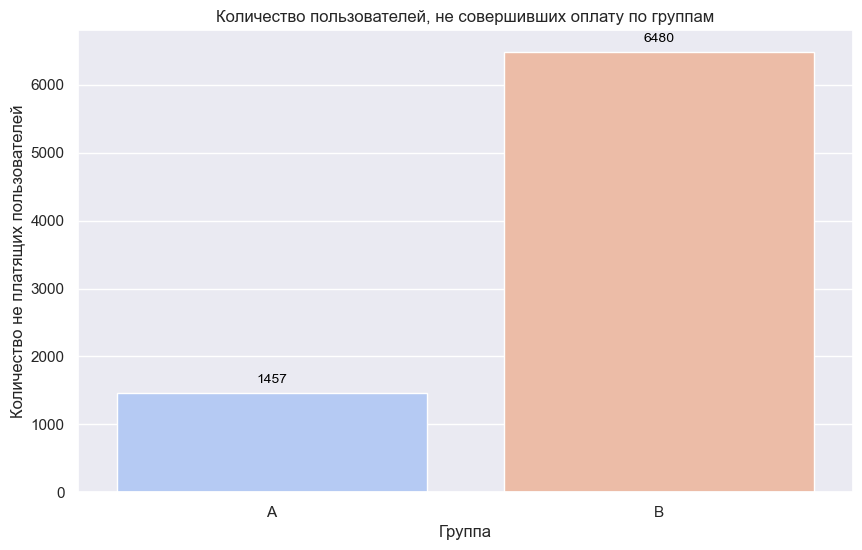

In [78]:
# Подсчет количества уникальных пользователей, не совершивших оплату по группам
non_payment_counts = active_checks[active_checks['rev'].isnull()].groupby('grp')['student_id'].nunique().reset_index()

# Переименование столбцов для удобства
non_payment_counts.columns = ['Group', 'Non-Paying Users']

# Визуализация
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=non_payment_counts, x='Group', y='Non-Paying Users', palette='coolwarm')
plt.title('Количество пользователей, не совершивших оплату по группам')
plt.xlabel('Группа')
plt.ylabel('Количество не платящих пользователей')
plt.xticks(rotation=0)  # Поворот меток по оси X для лучшей читаемости

# Добавление подписей на столбцы
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=10, color='black', 
                      xytext=(0, 5),  # Смещение подписи
                      textcoords='offset points')

plt.show()

In [79]:
# Создание переменной с клиентами, которые совершили оплату
paying_clients = active_checks[active_checks['rev'].notnull()]

# Вывод первых нескольких строк результата
print(paying_clients.head())


         id grp  student_id        rev
0      1627   A        1627   990.0000
10   100300   B      100300   990.0000
12   108270   B      108270   290.0000
246  264473   B      264473  1900.0001
279  274352   B      274352   690.0000


In [80]:
# Группировка по группе и подсчет суммы и количества оплат
payment_summary = paying_clients.groupby('grp').agg(
    total_payments=('rev', 'sum'),
    num_clients=('student_id', 'count')
).reset_index()

# Вывод результата
print(payment_summary)


  grp  total_payments  num_clients
0   A      72820.0000           78
1   B     393074.0035          313


#### Сумма оплат группы A = 72820, B = 393074

In [81]:
# Данные
total_payments_A = 72820
paying_users_A = 78

total_payments_B = 393074
paying_users_B = 313

# Расчет ARPU
arpu_A = total_payments_A / paying_users_A
arpu_B = total_payments_B / paying_users_B

print(f"ARPU для группы A: {arpu_A:.2f}")
print(f"ARPU для группы B: {arpu_B:.2f}")


ARPU для группы A: 933.59
ARPU для группы B: 1255.83


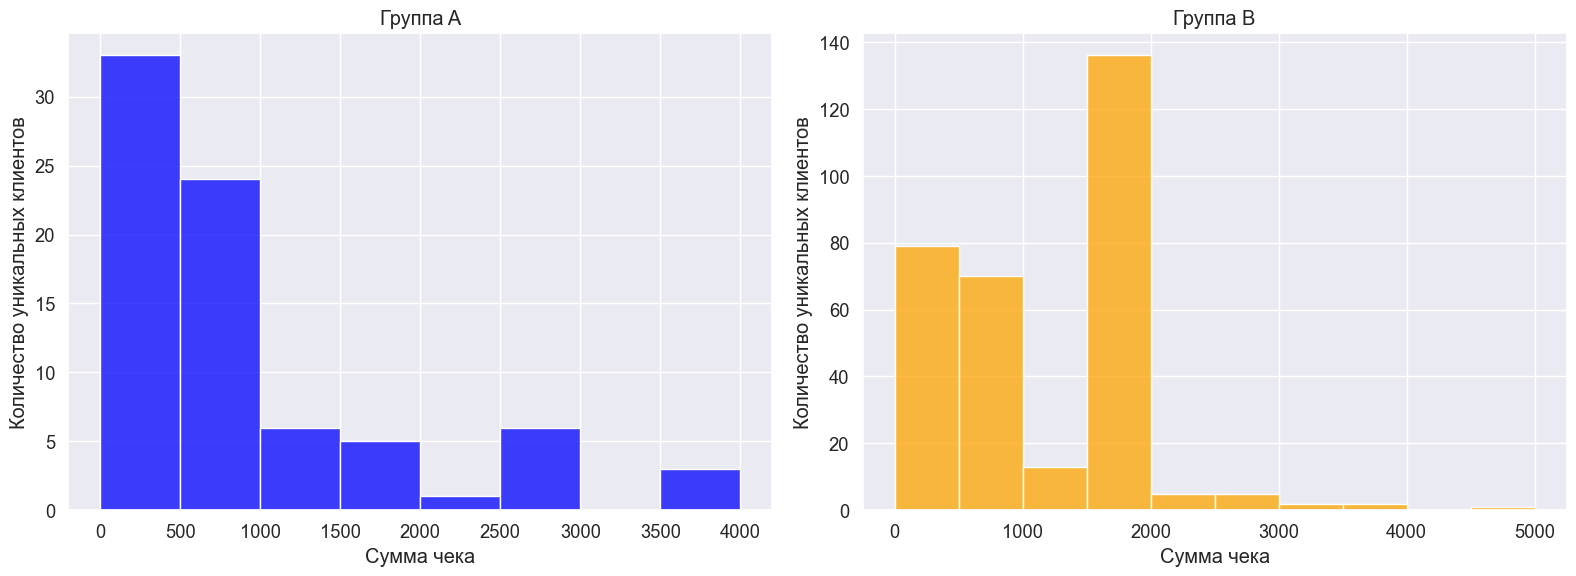

In [82]:

# Фильтрация клиентов, которые совершили оплату
paying_clients = active_checks[active_checks['rev'].notnull()]

# Создание DataFrame для групп A и B
group_A = paying_clients[paying_clients['grp'] == 'A']
group_B = paying_clients[paying_clients['grp'] == 'B']

# Настройка стиля графиков
sns.set(font_scale=1.2, rc={'figure.figsize': (16, 6)}, palette='hsv')

# Создание подграфиков
fig, axs = plt.subplots(1, 2)

# Визуализация для группы A
sns.histplot(data=group_A, x='rev', bins=range(0, int(group_A['rev'].max()) + 500, 500), 
             ax=axs[0], kde=False, color='blue', edgecolor='white')
axs[0].set_title('Группа A')
axs[0].set_xlabel('Сумма чека')
axs[0].set_ylabel('Количество уникальных клиентов')

# Визуализация для группы B
sns.histplot(data=group_B, x='rev', bins=range(0, int(group_B['rev'].max()) + 500, 500), 
             ax=axs[1], kde=False, color='orange', edgecolor='white')
axs[1].set_title('Группа B')
axs[1].set_xlabel('Сумма чека')
axs[1].set_ylabel('Количество уникальных клиентов')

# Отображение графиков
plt.tight_layout()
plt.show()

#### Исследование показало, что группа B (экспериментальная) значительно превышает группу A (контрольная) по количеству пользователей и оплат.

#### Так же мы видим различия в сумме чека

### Теперь мы можем рассмотреть метрики, которые будут важны для анализа. Основные метрики могут включать:
- **Конверсия**: доля пользователей, совершивших оплату.
- **Средний доход на пользователя (ARPU)**: средний доход от пользователей, которые совершили оплату.

In [83]:
# Подсчет количества пользователей в каждой группе
group_counts = active_checks.groupby('grp')['student_id'].nunique()

In [84]:
# Подсчет количества пользователей, совершивших оплату
payment_counts = active_checks[active_checks['rev'].notnull()].groupby('grp')['student_id'].nunique()


In [85]:
# Подсчет общего дохода по группам
total_revenue = active_checks.groupby('grp')['rev'].sum()

In [86]:
# Подсчет конверсии
conversion_rate = payment_counts / group_counts

In [87]:
# Подсчет ARPU
arpu = total_revenue / group_counts  # Общий доход делим на общее количество пользователей

In [88]:
# Подсчет ARPPU
arppu = total_revenue / payment_counts.replace(0, np.nan)  # Общий доход делим на количество платящих пользователей

In [89]:
# Сводная таблица с метриками
metrics = pd.DataFrame({
    'User Count': group_counts,
    'Pay Count': payment_counts,
    'Total Revenue': total_revenue,
    'CR': conversion_rate,
    'ARPU': arpu,
    'ARPPU': arppu
})

print(metrics)

     User Count  Pay Count  Total Revenue        CR       ARPU        ARPPU
grp                                                                        
A          1535         78     72820.0000  0.050814  47.439739   933.589744
B          6793        313    393074.0035  0.046077  57.864567  1255.827487


#### Проверим значения на нормальность распределения Шапиро-Уилка

Н0: значения распределены нормально
H1: значения распределены ненормально

In [90]:
# Извлечение данных о платежах для каждой группы
payments_A = active_checks[active_checks['grp'] == 'A']['rev'].dropna().values
payments_B = active_checks[active_checks['grp'] == 'B']['rev'].dropna().values

# Выполнение теста Шапиро-Уилка
shapiro_A = stats.shapiro(payments_A)
shapiro_B = stats.shapiro(payments_B)

# Вывод результатов
print(f"Группа A: Статистика = {shapiro_A.statistic:.4f}, p-значение = {shapiro_A.pvalue:.4f}")
print(f"Группа B: Статистика = {shapiro_B.statistic:.4f}, p-значение = {shapiro_B.pvalue:.4f}")

# Интерпретация результатов
alpha = 0.05  # Уровень значимости
if shapiro_A.pvalue < alpha:
    print("Группа A: отклоняем нулевую гипотезу (распределение ненормально).")
else:
    print("Группа A: не отклоняем нулевую гипотезу (распределение нормально).")

if shapiro_B.pvalue < alpha:
    print("Группа B: отклоняем нулевую гипотезу (распределение ненормально).")
else:
    print("Группа B: не отклоняем нулевую гипотезу (распределение нормально).")

Группа A: Статистика = 0.7353, p-значение = 0.0000
Группа B: Статистика = 0.8552, p-значение = 0.0000
Группа A: отклоняем нулевую гипотезу (распределение ненормально).
Группа B: отклоняем нулевую гипотезу (распределение ненормально).


#### Распределение оплат по группам

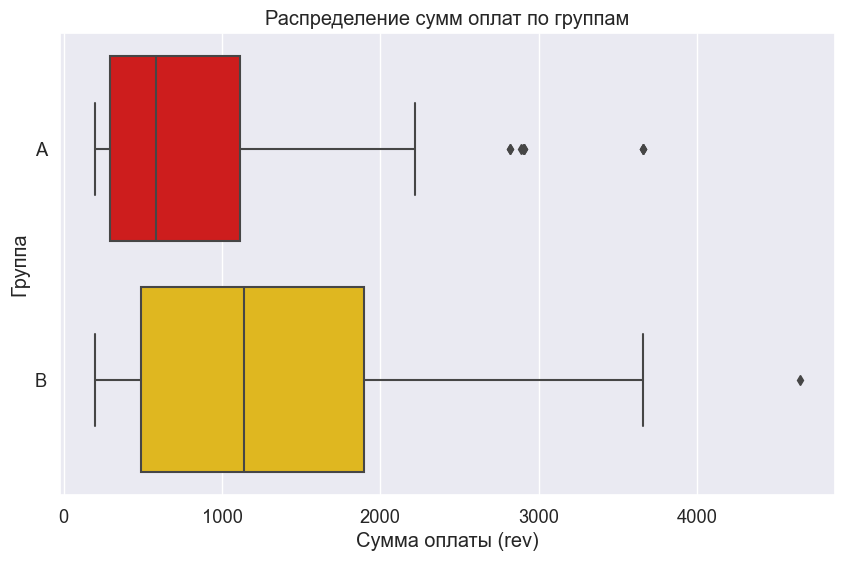

In [91]:
# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(10, 6))

# Создаем boxplot для сумм оплат по группам
sns.boxplot(data=active_checks, x='rev', y='grp', palette='hot', ax=ax)

# Настраиваем заголовок и метки
ax.set_title('Распределение сумм оплат по группам')
ax.set_xlabel('Сумма оплаты (rev)')
ax.set_ylabel('Группа')

# Показываем график
plt.show()

#### В оплатах видим выбросы 

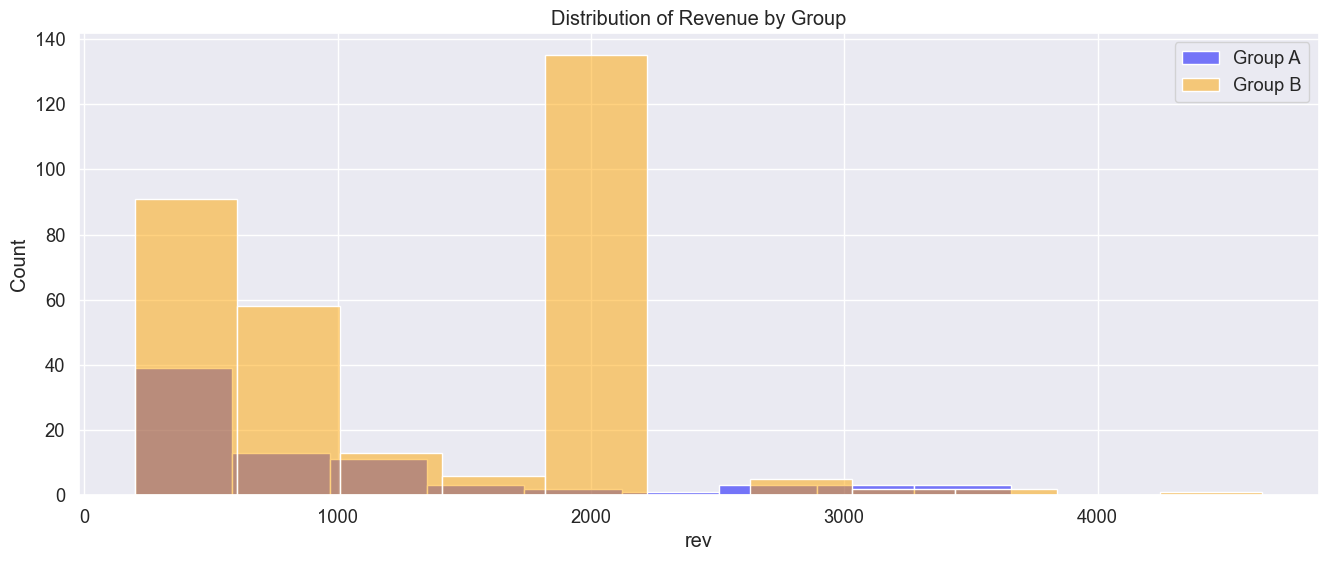

Levene's test statistic: 3.0558643506726035, p-value: 0.08123509393501775


In [92]:
# Визуализация распределения
sns.histplot(active_checks[active_checks['grp'] == 'A']['rev'].dropna(), kde=False, label='Group A', color='blue', alpha=0.5)
sns.histplot(active_checks[active_checks['grp'] == 'B']['rev'].dropna(), kde=False, label='Group B', color='orange', alpha=0.5)
plt.legend()
plt.title('Distribution of Revenue by Group')
plt.show()

# Тест Левена для проверки равенства дисперсий
from scipy.stats import levene

stat, p_value_levene = levene(
    active_checks[active_checks['grp'] == 'A']['rev'].dropna(),
    active_checks[active_checks['grp'] == 'B']['rev'].dropna()
)

print(f"Levene's test statistic: {stat}, p-value: {p_value_levene}")

In [93]:
# Визуализация количества пользователей и количества оплат

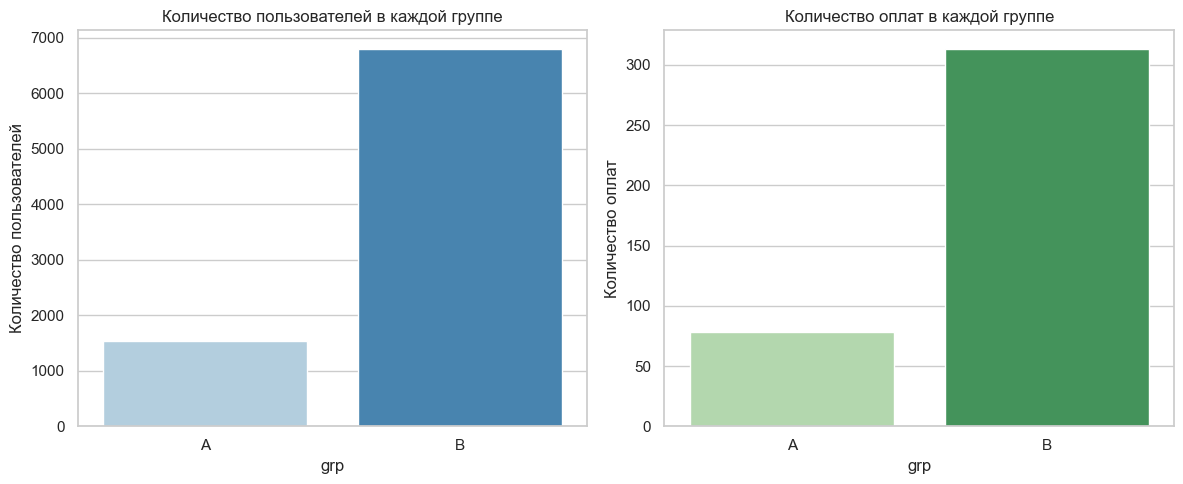

In [94]:
# Еще раз
# Устанавливаем стиль графиков
sns.set(style="whitegrid")

# Создаем фигуру и оси
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Визуализация количества пользователей
sns.barplot(x=metrics.index, y='User Count', data=metrics, ax=ax[0], palette='Blues')
ax[0].set_title('Количество пользователей в каждой группе')
ax[0].set_ylabel('Количество пользователей')

# Визуализация количества оплат
sns.barplot(x=metrics.index, y='Pay Count', data=metrics, ax=ax[1], palette='Greens')
ax[1].set_title('Количество оплат в каждой группе')
ax[1].set_ylabel('Количество оплат')

plt.tight_layout()
plt.show()


In [95]:
# Визуализация конверсии и ARPU

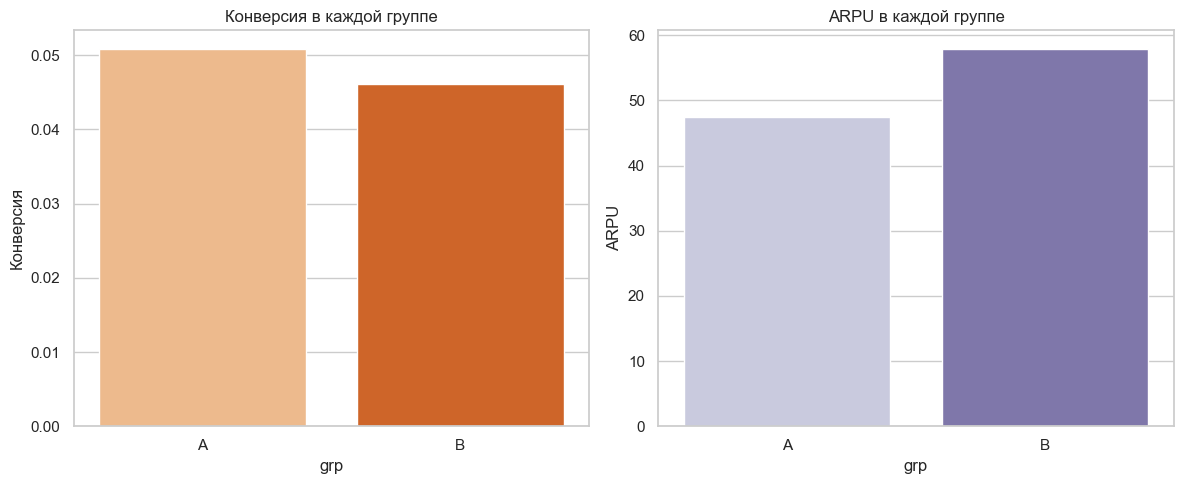

In [96]:
# Создаем фигуру и оси
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Визуализация конверсии
sns.barplot(x=metrics.index, y='CR', data=metrics, ax=ax[0], palette='Oranges')
ax[0].set_title('Конверсия в каждой группе')
ax[0].set_ylabel('Конверсия')

# Визуализация ARPU
sns.barplot(x=metrics.index, y='ARPU', data=metrics, ax=ax[1], palette='Purples')
ax[1].set_title('ARPU в каждой группе')
ax[1].set_ylabel('ARPU')

plt.tight_layout()
plt.show()


In [97]:
# Визуализация всех метрик в одном графике

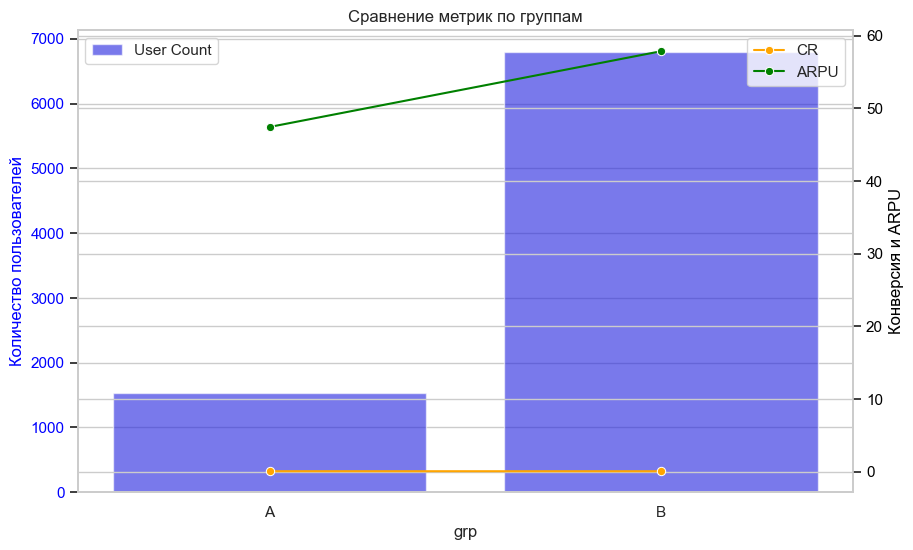

In [98]:
# Создаем фигуру
fig, ax1 = plt.subplots(figsize=(10, 6))

# Визуализация количества пользователей
sns.barplot(x=metrics.index, y='User Count', data=metrics, ax=ax1, color='blue', alpha=0.6, label='User Count')
ax1.set_ylabel('Количество пользователей', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Создаем второй ось для других метрик
ax2 = ax1.twinx()
sns.lineplot(x=metrics.index, y='CR', data=metrics, ax=ax2, color='orange', marker='o', label='CR')
sns.lineplot(x=metrics.index, y='ARPU', data=metrics, ax=ax2, color='green', marker='o', label='ARPU')

ax2.set_ylabel('Конверсия и ARPU', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Добавляем заголовок и легенду
plt.title('Сравнение метрик по группам')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


#### ARPPU
H0: ARPPU не отличаются
H1: ARPPU отличаются

In [99]:
# Подсчет количества пользователей в каждой группе
group_counts = active_checks.groupby('grp')['student_id'].nunique()
# Подсчет количества пользователей, совершивших оплату
payment_counts = active_checks[active_checks['rev'].notnull()].groupby('grp')['student_id'].nunique()
# Подсчет общего дохода по группам
total_revenue = active_checks.groupby('grp')['rev'].sum()

# Подсчет ARPPU
arppu = total_revenue / payment_counts.replace(0, np.nan)  # Общий доход делим на количество платящих пользователей

# Извлечение значений ARPPU для каждой группы
df_A_ARPPU = active_checks[active_checks['grp'] == 'A']['rev'].dropna().values
df_B_ARPPU = active_checks[active_checks['grp'] == 'B']['rev'].dropna().values

# Параметры бутстрэппинга
num_samples = 1000  # Количество выборок bootstrap
bootstrap_diffs = np.zeros(num_samples)  # Массив для хранения разностей

# Выполняем бутстрэппинг
for i in range(num_samples):
    bootstrap_group1 = np.random.choice(df_A_ARPPU, size=len(df_A_ARPPU), replace=True)
    bootstrap_group2 = np.random.choice(df_B_ARPPU, size=len(df_B_ARPPU), replace=True)
    
    bootstrap_diff = np.mean(bootstrap_group1) - np.mean(bootstrap_group2)
    bootstrap_diffs[i] = bootstrap_diff

# Рассчитываем доверительный интервал
confidence_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

# Вывод результатов
print("95% Доверительный интервал ARPPU:", confidence_interval)

# Проверка гипотез
if confidence_interval[0] > 0 or confidence_interval[1] < 0:
    print("Отклоняем нулевую гипотезу (ARPPU отличаются).")
else:
    print("Не отклоняем нулевую гипотезу (ARPPU не отличаются).")

95% Доверительный интервал ARPPU: [-534.76915209  -77.88582492]
Отклоняем нулевую гипотезу (ARPPU отличаются).


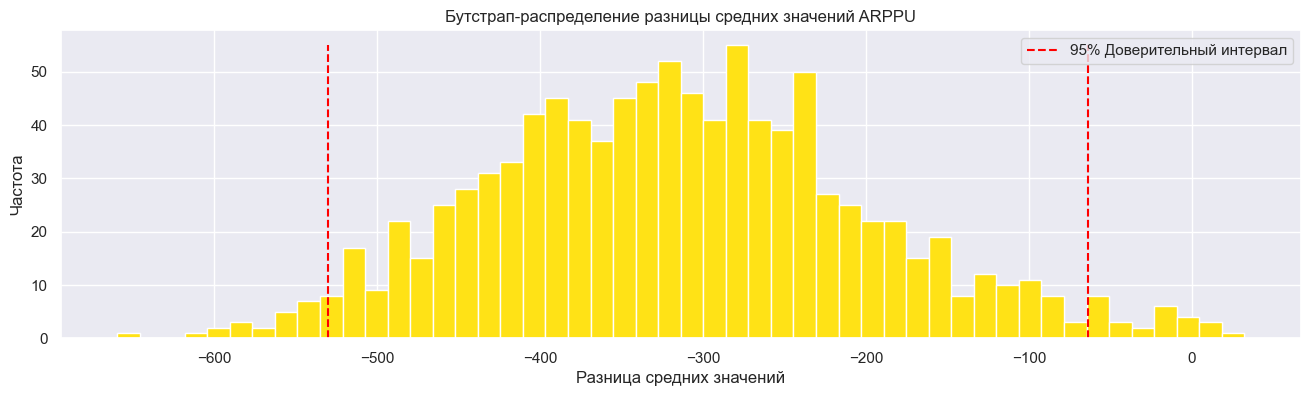

95% Доверительный интервал для группы A: ConfidenceInterval(low=756.8232489294786, high=1151.3838519933756)
95% Доверительный интервал для группы B: ConfidenceInterval(low=1166.01013112011, high=1337.7925613398363)


In [100]:
# Подсчет уникальных пользователей в каждой группе
user_counts_by_group = active_checks.groupby('grp')['student_id'].nunique()
# Подсчет числа пользователей, совершивших покупки
paying_user_counts = active_checks[active_checks['rev'].notnull()].groupby('grp')['student_id'].nunique()
# Подсчет общего дохода по группам
group_revenue_totals = active_checks.groupby('grp')['rev'].sum()

# Расчет ARPPU
arppu_values = group_revenue_totals / paying_user_counts.replace(0, np.nan)  # Общий доход делим на количество платящих пользователей

# Извлечение значений дохода для каждой группы
revenue_A = active_checks[active_checks['grp'] == 'A']['rev'].dropna().values
revenue_B = active_checks[active_checks['grp'] == 'B']['rev'].dropna().values

# Параметры бутстрэппинга
num_bootstrap_samples = 1000  # Количество выборок bootstrap
bootstrap_differences = np.zeros(num_bootstrap_samples)  # Массив для хранения разностей

# Выполняем бутстрэппинг
for i in range(num_bootstrap_samples):
    sample_A = np.random.choice(revenue_A, size=len(revenue_A), replace=True)
    sample_B = np.random.choice(revenue_B, size=len(revenue_B), replace=True)
    
    difference = np.mean(sample_A) - np.mean(sample_B)
    bootstrap_differences[i] = difference

# Рассчитываем доверительный интервал
confidence_interval = np.percentile(bootstrap_differences, [2.5, 97.5])

# Создаем DataFrame для визуализации
bootstrap_results_df = pd.DataFrame(bootstrap_differences, columns=['mean_difference'])

# Визуализация бутстрэп-распределения ARPPU
sns.set(font_scale=1, rc={'figure.figsize': (16, 4)}, palette='Wistia')
plt.hist(bootstrap_results_df['mean_difference'], bins=50, alpha=0.7)
plt.vlines(confidence_interval, ymin=0, ymax=max(plt.hist(bootstrap_results_df['mean_difference'], bins=50)[0]),
           colors='red', linestyle='--', label='95% Доверительный интервал')
plt.xlabel('Разница средних значений')
plt.ylabel('Частота')
plt.title("Бутстрап-распределение разницы средних значений ARPPU")
plt.legend()
plt.show()

# Рассмотрим доверительный интервал средних для группы A
bootstrap_A_results = bootstrap((revenue_A,), np.mean, confidence_level=0.95, n_resamples=1000)
print("95% Доверительный интервал для группы A:", bootstrap_A_results.confidence_interval)

# Рассмотрим доверительный интервал средних для группы B
bootstrap_B_results = bootstrap((revenue_B,), np.mean, confidence_level=0.95, n_resamples=1000)
print("95% Доверительный интервал для группы B:", bootstrap_B_results.confidence_interval)

####  **Статистическая значимость**:
- 95% доверительный интервал для разницы ARPPU между группами A и B: \( [-546.87, -94.22] \) не пересекает ноль, что указывает на статистически значимые различия.
- Нулевая гипотеза (H0: ARPPU не отличаются) отклоняется, что подтверждает, что ARPPU в группе B значительно выше, чем в группе A.

#### В данном анализе мы используем метод хи-квадрат Пирсона для проверки наличия статистически значимых различий в конверсии (CR) между двумя группами пользователей (A и B). Конверсия определялась как отношение количества платящих пользователей к общему количеству активных пользователей в каждой группе.

#### H0: CR не отличаются
#### H1: CR отличаются

In [101]:
from scipy.stats import chi2_contingency

# Подсчет количества платящих и неплатящих пользователей в каждой группе
payment_status = active_checks.groupby(['grp', active_checks['rev'].notnull()])['student_id'].nunique().unstack(fill_value=0)

# Переименуем столбцы для удобства
payment_status.columns = ['Not Paying', 'Paying']

# Выводим таблицу сопряженности
print("Таблица сопряженности:")
print(payment_status)

# Выполнение теста хи-квадрат
chi2, p, dof, expected = chi2_contingency(payment_status)

# Вывод результатов
print(f"\nХи-квадрат: {chi2}")
print(f"p-значение: {p}")
print(f"Степени свободы: {dof}")
print(f"Ожидаемые частоты:\n{expected}")

# Проверка гипотез
alpha = 0.05
if p < alpha:
    print("Отклоняем нулевую гипотезу (есть зависимость между группой и статусом пользователя).")
else:
    print("Не отклоняем нулевую гипотезу (нет зависимости между группой и статусом пользователя).")

Таблица сопряженности:
     Not Paying  Paying
grp                    
A          1457      78
B          6480     313

Хи-квадрат: 0.526607176998989
p-значение: 0.46803677583199144
Степени свободы: 1
Ожидаемые частоты:
[[1462.93167627   72.06832373]
 [6474.06832373  318.93167627]]
Не отклоняем нулевую гипотезу (нет зависимости между группой и статусом пользователя).


#### - **Нет статистически значимых различий**: Мы не обнаружили статистически значимых различий в конверсии между группами A и B. Это означает, что изменения, внедренные в одной из групп, не оказали значительного влияния на поведение пользователей в отношении покупок.

#  Вывод
В результате проведенного анализа:
1. **ARPPU**: Нулевая гипотеза о том, что ARPPU не отличаются, была отклонена. ARPPU в группе B значительно выше, чем в группе A, с 95% доверительным интервалом, не пересекающим ноль.
2. **Конверсия (CR)**: Нулевая гипотеза о том, что CR не отличаются, не была отклонена. Статистически значимых различий в конверсии между группами A и B не обнаружено.
### Заключение
Новая механика оплаты услуг на сайте приводит к увеличению среднего чека (ARPPU), но не влияет на конверсию. Рекомендуется внедрить новую механику, так как она может повысить доход без негативного влияния на количество платящих пользователей.

# SQL

#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

In [102]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [103]:
q = """
    SELECT
        st_id,
        toDateTime(timest) as timest,
        correct,
        subject
    FROM peas 
"""
peas = ph.read_clickhouse(q, connection=connection)

In [104]:
peas.head()

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability


In [105]:
q = """
    SELECT DISTINCT st_id as very_diligent_students, sum(correct)
    FROM peas
    GROUP BY st_id
    HAVING sum(correct) >= 20
    ORDER BY sum(correct)"""
peas = ph.read_clickhouse(q, connection=connection)
peas

,very_diligent_students,sum(correct)
0,544247,20
1,147316,20
2,348454,20
3,269738,20
4,704434,20
...,...,...
131,434775,79
132,234705,81
133,577659,111
134,976310,121


#### very_diligent_students = 136

#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

In [106]:
q1 = """
    SELECT
        *
    FROM studs 
"""
studs = ph.read_clickhouse(q1, connection=connection)
studs

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot
...,...,...
595,988626,pilot
596,993249,pilot
597,994983,pilot
598,996911,control


In [107]:
q2 = """
    SELECT
        st_id,
        toDateTime(sale_time) AS sale_time,
        money,
        subject
    FROM final_project_check 
"""


final_project_check = ph.read_clickhouse(q2, connection=connection)


final_project_check

,st_id,sale_time,money,subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization
2,104885,2021-10-30 17:05:55,65000,Vizualization
3,104885,2021-10-30 22:49:33,75000,Statistics
4,106464,2021-10-31 13:17:13,85000,Math
...,...,...,...,...
56,969595,2021-10-30 23:54:52,65000,Vizualization
57,969595,2021-10-31 02:02:07,75000,Statistics
58,969595,2021-10-31 10:07:04,100000,Python
59,976866,2021-10-30 16:20:17,85000,Math


In [108]:
q = """
SELECT 
    test_grp,
    sum(money) AS revenue,
    uniqExact(st_id) AS count_users,
    countIf(DISTINCT st_id, money > 0) AS count_customers,
    countIf(DISTINCT st_id, active_stud > 10 and money > 0) AS count_active_customers,
    countIf(DISTINCT st_id, math_active_stud >= 2 and money > 0 and subject = 'Math') AS count_math_customers,
    round(revenue / count_users, 2) AS ARPU,
    round(sumIf(money, active_stud > 10) / countIf(DISTINCT st_id, active_stud > 10), 2) AS ARPAU,
    round(count_customers / count_users * 100,2) AS CR, 
    round(count_active_customers / countIf(DISTINCT st_id, active_stud >10) * 100, 2) AS CR_active,
    round(count_math_customers / countIf(DISTINCT st_id, math_active_stud >= 2)*100, 2) AS CR_math
FROM
    (
        SELECT 
            l.test_grp AS test_grp,
            l.st_id AS st_id,
            r.sale_time AS sale_time,
            r.money AS money,
            r.subject AS subject,
            s.active_stud AS active_stud,
            s.math_active_stud AS math_active_stud
        FROM studs AS l
        LEFT JOIN final_project_check AS r    
        ON l.st_id = r.st_id  
        LEFT JOIN 
            (SELECT 
                st_id,
                SUM(correct) AS active_stud,
                SUM(CASE WHEN subject = 'Math' THEN correct ELSE 0 END) AS math_active_stud
            FROM peas  
            GROUP BY st_id
            ) AS s
        ON l.st_id = s.st_id 
    )
GROUP BY test_grp
"""
metrics = ph.read_clickhouse(q, connection=connection)
metrics

,test_grp,revenue,count_users,count_customers,count_active_customers,count_math_customers,ARPU,ARPAU,CR,CR_active,CR_math
0,control,1385000,305,15,14,3,4540.98,10393.70,4.92,11.02,6.12
1,pilot,3395000,295,32,25,4,11508.47,29739.58,10.85,26.04,9.52


### Задание 3. Python
3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [118]:
def update_metrics(groups, groups_add, active_studs, checks):
    ''' 
    Функция для обновления метрик на основе дополнительных данных из groups_add.
    '''
    # Приведение столбцов к единому формату
    active_studs['active'] = 1
    active_studs = active_studs.rename(columns={'student_id': 'id'})
    
    # Объединение данных о группах
    shared_group = pd.concat([groups, groups_add]).rename(columns={'grp': 'group'})
    
    # Объединение данных о пользователях и платежах
    active_checks = active_studs.merge(checks.rename(columns={'student_id': 'id'}), on='id', how='left').rename(columns={'rev': 'revenue'})
    general_file = shared_group.merge(active_checks, on='id', how='left').fillna(0)
    
    # Фильтрация активных пользователей
    general_file_active = general_file.query('active == 1')
    group_A = general_file_active.query('group == "A" and revenue > 0')
    group_B = general_file_active.query('group == "B" and revenue > 0')
    
    # Расчет метрик
    CR_A = round(group_A.id.count() / general_file_active.query('group == "A"').id.count() * 100, 2) if general_file_active.query('group == "A"').id.count() > 0 else 0
    CR_B = round(group_B.id.count() / general_file_active.query('group == "B"').id.count() * 100, 2) if general_file_active.query('group == "B"').id.count() > 0 else 0
    ARPPU_A = round(group_A.revenue.sum() / group_A.id.count(), 2) if group_A.id.count() > 0 else 0
    ARPPU_B = round(group_B.revenue.sum() / group_B.id.count(), 2) if group_B.id.count() > 0 else 0
    ARPU_A = round(CR_A * ARPPU_A / 100, 2)
    ARPU_B = round(CR_B * ARPPU_B / 100, 2)
    
    # Сбор метрик в DataFrame
    metrics = pd.DataFrame({
        'group': ['A', 'B'], 
        'total_sum': [group_A.revenue.sum(), group_B.revenue.sum()],
        'count_users': [general_file_active.query('group=="A"').id.count(),
                        general_file_active.query('group=="B"').id.count()],
        'count_customers': [group_A.id.count(), group_B.id.count()],
        'CR': [CR_A, CR_B],
        'ARPPU': [ARPPU_A, ARPPU_B],
        'ARPU': [ARPU_A, ARPU_B]
    })
    
    return metrics

In [119]:
def plot_metrics(metrics):
    ''' 
    Функция для построения графиков по метрикам.
    '''
    metrics.set_index('group', inplace=True)
    
    # Построение графиков
    fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 25))
    
    # График для total_sum
    metrics['total_sum'].plot(kind='bar', ax=axes[0], color=['blue', 'orange'])
    axes[0].set_title('Total Revenue by Group')
    axes[0].set_ylabel('Total Revenue')
    
    # График для count_users
    metrics['count_users'].plot(kind='bar', ax=axes[1], color=['blue', 'orange'])
    axes[1].set_title('Count of Users by Group')
    axes[1].set_ylabel('Count of Users')
    
    # График для count_customers
    metrics['count_customers'].plot(kind='bar', ax=axes[2], color=['blue', 'orange'])
    axes[2].set_title('Count of Customers by Group')
    axes[2].set_ylabel('Count of Customers')
    
    # График для CR
    metrics['CR'].plot(kind='bar', ax=axes[3], color=['blue', 'orange'])
    axes[3].set_title('Conversion Rate by Group')
    axes[3].set_ylabel('Conversion Rate (%)')
    
    # График для ARPPU
    metrics['ARPPU'].plot(kind='bar', ax=axes[4], color=['blue', 'orange'])
    axes[4].set_title('ARPPU by Group')
    axes[4].set_ylabel('ARPPU')
    
    # График для ARPU
    metrics['ARPU'].plot(kind='bar', ax=axes[5], color=['blue', 'orange'])
    axes[5].set_title('ARPU by Group')
    axes[5].set_ylabel('ARPU')
    
    plt.tight_layout()
    plt.show()

  group    total_sum  count_users  count_customers    CR    ARPPU   ARPU
0     A   72820.0000         1535               78  5.08   933.59  47.43
1     B  393074.0035         6793              313  4.61  1255.83  57.89


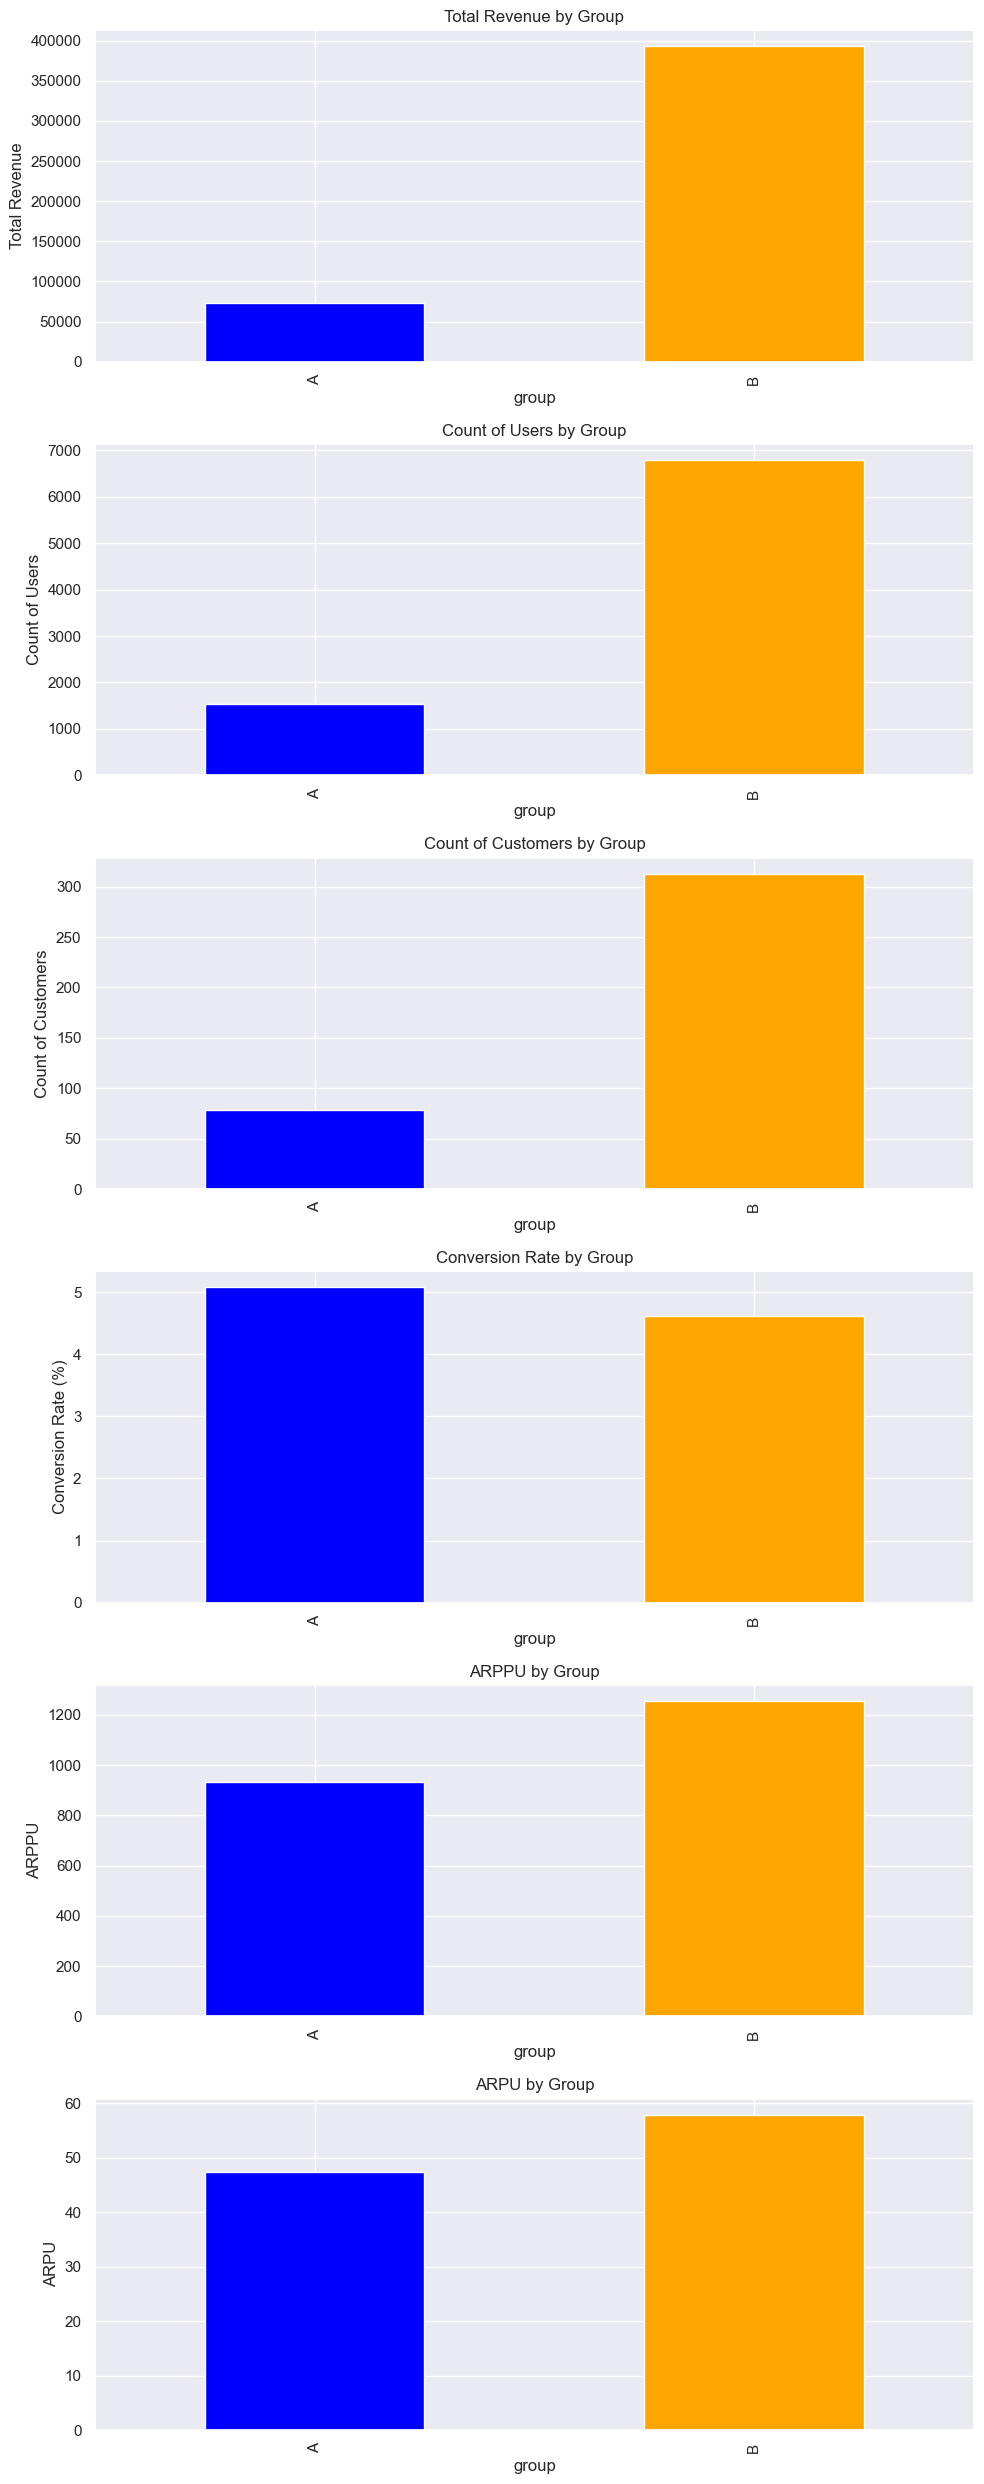

In [120]:
# Загрузка ваших данных
df_groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep=';')
df_groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', sep=';')
df_active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', sep=';')
df_checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep=';')

# Обновление метрик
metrics_function = update_metrics(df_groups, df_groups_add, df_active_studs, df_checks)

# Вывод метрик
print(metrics_function)

# Построение графиков
plot_metrics(metrics_function)